In [347]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib
import numpy as np
import pandas as pd

for font in font_manager.findSystemFonts('/Users/leonardokuffo/Library/Fonts/'):
    font_manager.fontManager.addfont(font)

matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
matplotlib.rc('font', family='Droid Serif') 

In [348]:
DATASETS_MAPPING = {
    'nytimes-16-angular': 'NYTimes/16',
    'glove-50-angular': 'GloVe/50',
    'deep-image-96-angular': 'DEEP/96',
    'sift-128-euclidean': 'SIFT/128',
    'glove-200-angular': 'GloVe/200',
    'msong-420': 'MSong/420',
    'contriever-768': 'Contriever/768',
    'instructorxl-arxiv-768': 'arXiv/768',
    'gist-960-euclidean': 'GIST/960',
    'openai-1536-angular': 'OpenAI/1536',
}
#arch = 'SAPPHIRE'
arch = 'ZEN4_INSITU'
#arch = 'ZEN4_AWS'
#arch = 'ZEN3'
#arch = 'GRAVITON4'
#arch = 'M1'

In [349]:
faiss = pd.read_csv(f'../{arch}/IVF_FAISS.csv', index_col=False)
milvus = pd.read_csv(f'../{arch}/IVF_MILVUS.csv', index_col=False)
ads = pd.read_csv(f'../{arch}/IVF_NARY_ADSAMPLING.csv', index_col=False)
ads_simd = pd.read_csv(f'../{arch}/IVF_NARY_ADSAMPLING_SIMD.csv', index_col=False)
pdx_ads = pd.read_csv(f'../{arch}/IVF_PDX_ADSAMPLING.csv', index_col=False)
pdx = pd.read_csv(f'../{arch}/IVF_PDX_VERTICAL_SCAN.csv', index_col=False)
bsa = pd.read_csv(f'../{arch}/IVF_NARY_BSA.csv', index_col=False)
pdx_bsa = pd.read_csv(f'../{arch}/IVF_PDX_BSA.csv', index_col=False)

faiss['algorithm'] = 'FAISS-IVF'
milvus['algorithm'] = 'MILVUS-IVF'
ads['algorithm'] = 'SCALAR-ADS'
ads_simd['algorithm'] = 'SIMD-ADS'
pdx_ads['algorithm'] = 'PDX-ADS'
pdx['algorithm'] = 'PDX-LinearScan'
bsa['algorithm'] = 'SIMD-BSA'
pdx_bsa['algorithm'] = 'PDX-BSA'

df = pd.concat([
    faiss, 
    milvus,
    pdx_ads,
    ads, 
    ads_simd,
    #pdx,
    #bsa,
    #pdx_bsa
], ignore_index=True)
df = df.groupby(['algorithm', 'dataset', 'recall']).agg({
    'avg': 'min',
    'max': 'min',
    'min': 'min',
    'ivf_nprobe': 'min',
}).reset_index().sort_values(['algorithm', 'dataset', 'ivf_nprobe'])
df['avg'] = 1000 / df['avg']
df = df[['algorithm', 'dataset', 'recall', 'avg']]
df.columns =  ['Algorithm', 'Dataset', 'Recall', 'QPS']

df = df[df['Recall'] >= 0.87]

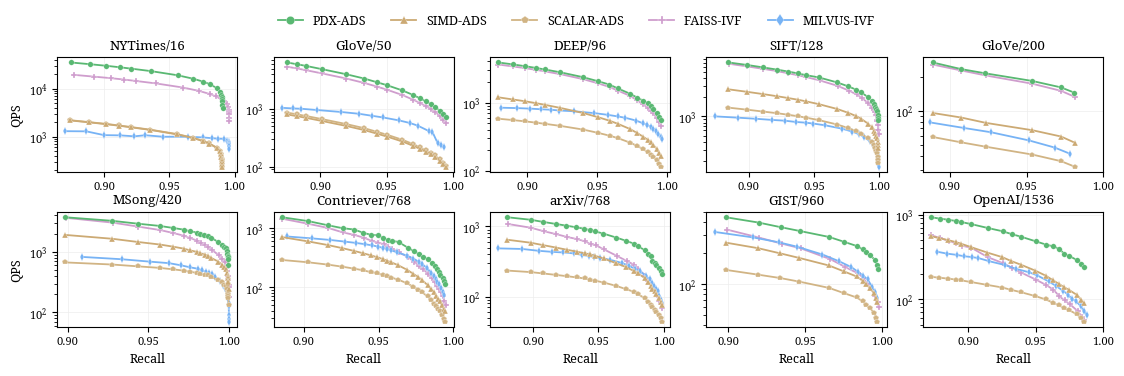

In [350]:
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import LogFormatter, FormatStrFormatter

colors = {
    'FAISS-IVF': '#cf9dcd',
    'MILVUS-IVF': '#77b3f5',
    'PDX-ADS': '#59b872',
    'SIMD-ADS': '#ccaa74',
    'SCALAR-ADS': '#d1b484',
    'PDX-LinearScan': '#B8A159',
    #'PDX-BSA': '#B8A159',
    #'SIMD-BSA': '#B8A159',
}


dashes = {
    'FAISS-IVF': '',
    'MILVUS-IVF': '',
    'PDX-ADS': '',
    'SIMD-ADS': '',
    'SCALAR-ADS': '',
    'PDX-LinearScan': '',
    #'PDX-BSA': '',
    #'SIMD-BSA': '',
}

markers = ['P', 'd', 'o', 'p', '^']

order = list(range(len(df['Algorithm'].unique()))) # [1,2,0,3,4]
order = [2, 4, 3, 0, 1]
# c48b6a

[',', '.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

font = {'size': 8}
matplotlib.rc('font', **font)

fig, (
    (ax1, ax2, ax3, ax4, ax5),
    (ax9, ax10, ax11, ax12, ax13),
) = plt.subplots(2, 5, constrained_layout=False)
fig.set_size_inches(13.5, 3.5)
plots = [ax1, ax2, ax3, ax4, ax5, ax9, ax10, ax11, ax12, ax13]

plt.subplots_adjust(hspace=0.35, wspace=0.20)

for i, dataset in enumerate(list(DATASETS_MAPPING.keys())[:]):
    ax = plots[i]
    dataset_name = DATASETS_MAPPING[dataset]
    to_plot = df[df['Dataset'] == dataset]
    
    sns.lineplot(
        data=to_plot,
        x="Recall", 
        y="QPS",
        hue="Algorithm",
        markers=markers,
        dashes=dashes,
        palette=colors,
        style='Algorithm',
        linewidth=1.3,
        markeredgewidth=0.2,
        markersize=4,
        ax=ax,
    )
    
    ax.xaxis.grid(linewidth=0.5, color='#ededed')
    ax.yaxis.grid(linewidth=0.5, color='#ededed')
    ax.set_axisbelow(True)

    if (i == 0):
        handles, labels = ax.get_legend_handles_labels()
        order = order
        ax.legend(
            [handles[idx] for idx in order],[labels[idx] for idx in order],
            loc="upper left",
            prop={'size': 9},
            ncols=len(order),
            frameon=False,
            # bbox_to_anchor=(2.60, 1.60), # for when 4 are plotted
            bbox_to_anchor=(1.16, 1.47),
            markerscale=1.5
        )
    ax.set_title(dataset_name)
    ax.set_xlabel(f'Recall', fontsize=9)
    ax.set_ylabel('QPS', fontsize=9)
    ax.set_yscale('log')
    if (i != 0):
        ax.legend().remove()
    if (i != 0 and i != 5):
        ax.set_ylabel('')
    if (i < 5):
        ax.set_xlabel('')
    if dataset_name in ['STL/9216', 'Trevi/4096']:
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.set_xticks([0.90, 0.95, 1.0])


plt.savefig(f'../figures/PDXEARCH_{arch}.png', format='png', dpi=600, bbox_inches='tight')

In [335]:
combined = faiss.merge(
    ads, on=['dataset', 'ivf_nprobe'], how='inner', suffixes=('_faiss', '_ads')
).merge(
    pdx_ads, on=['dataset', 'ivf_nprobe'], how='inner', suffixes=('', '_pdx_ads') # This is the owner of 'avg'
).merge(
    ads_simd, on=['dataset', 'ivf_nprobe'], how='inner', suffixes=('', '_simd')
).merge(
    pdx, on=['dataset', 'ivf_nprobe'], how='inner', suffixes=('', '_pdx')
).merge(
    bsa, on=['dataset', 'ivf_nprobe'], how='inner', suffixes=('', '_bsa')
).merge(
    pdx_bsa, on=['dataset', 'ivf_nprobe'], how='inner', suffixes=('', '_pdx_bsa')
).merge(
    milvus, on=['dataset', 'ivf_nprobe'], how='inner', suffixes=('', '_milvus')
)

HIGH_DATASETS_MAPPING = {
    'msong-420': 'MSong/420',
    'contriever-768': 'Contriever/768',
    'instructorxl-arxiv-768': 'arXiv/768',
    'gist-960-euclidean': 'GIST/960',
    'openai-1536-angular': 'OpenAI/1536',
}

combined = combined[['dataset', 'recall_faiss', 'ivf_nprobe', 'avg_faiss', 'avg_ads', 'avg', 'avg_simd', 'avg_pdx', 'avg_bsa', 'avg_pdx_bsa', 'avg_milvus']]


combined['avg_faiss'] = 1000 / combined['avg_faiss']
combined['avg_milvus'] = 1000 / combined['avg_milvus']
combined['avg_ads'] = 1000 / combined['avg_ads']
combined['avg_pdx_ads'] = 1000 / combined['avg']
combined['avg_ads_simd'] = 1000 / combined['avg_simd']
combined['avg_bsa'] = 1000 / combined['avg_bsa']
combined['avg_pdx_bsa'] = 1000 / combined['avg_pdx_bsa']
combined['avg_pdx'] = 1000 / combined['avg_pdx']

# Taking the minimum nprobe to achieve the highest possible recall 
combined = combined.groupby(['dataset', 'recall_faiss']).last().reset_index().groupby(['dataset']).last().reset_index()
#combined = combined[combined['dataset'].isin(list(DATASETS_MAPPING.keys()))]
combined = combined[combined['dataset'].isin(list(HIGH_DATASETS_MAPPING.keys()))]
#combined = combined[combined['recall_linear'] > 0.95]


combined['speedup_ads'] = combined['avg_pdx_ads'] / combined['avg_ads']
combined['speedup_bsa'] = combined['avg_pdx_bsa'] / combined['avg_bsa']

combined['speedup_pdx_ads_faiss'] = combined['avg_pdx_ads'] / combined['avg_faiss']
combined['speedup_pdx_ads_simd'] = combined['avg_pdx_ads'] / combined['avg_ads_simd']
combined['speedup_pdx_ads_scalar'] = combined['avg_pdx_ads'] / combined['avg_ads']
combined['speedup_ads_pdx_milvus'] = combined['avg_pdx_ads'] / combined['avg_milvus']

combined['speedup_ads_simd_faiss'] = combined['avg_ads_simd'] /  combined['avg_faiss']
combined['speedup_ads_pdx_linear_faiss'] = combined['avg_pdx'] / combined['avg_faiss']

combined['speedup_faiss_ads'] = combined['avg_faiss'] / combined['avg_ads_simd']
combined['speedup_milvus_ads'] = combined['avg_milvus'] / combined['avg_ads_simd']

print('Results for', arch)
print('Average Speedup of ADSampling-PDX vs ADSampling-SIMD:', combined['speedup_pdx_ads_simd'].mean())
print('Average Speedup of ADSampling-PDX vs ADSampling-Scalar:', combined['speedup_ads'].mean())
print('Average Speedup of ADSampling-PDX against FAISS:', combined['speedup_pdx_ads_faiss'].mean())
print('Average Speedup of ADSampling-PDX against Milvus:', combined['speedup_ads_pdx_milvus'].mean())
print('Average Speedup of ADSampling-SIMD against FAISS:', combined['speedup_ads_simd_faiss'].mean())
print('Average Speedup of PDX-LinearScan against FAISS:', combined['speedup_ads_pdx_linear_faiss'].mean())
print('Average Speedup of BSA-PDX vs BSA-SIMD:', combined['speedup_bsa'].mean())
print('Average Speedup of FAISS vs ADSampling-SIMD:', combined['speedup_faiss_ads'].mean())
print('Average Speedup of Milvus vs ADSampling-SIMD:', combined['speedup_milvus_ads'].mean())

combined[[
    'dataset', 'recall_faiss', 'ivf_nprobe', 
    'speedup_pdx_ads_simd', 'speedup_ads', 'speedup_pdx_ads_faiss', 
    'speedup_ads_pdx_milvus', 'speedup_ads_simd_faiss', 'speedup_ads_pdx_linear_faiss', 'speedup_bsa']]

Results for ZEN4_INSITU
Average Speedup of ADSampling-PDX vs ADSampling-SIMD: 2.590144174280956
Average Speedup of ADSampling-PDX vs ADSampling-Scalar: 4.259923789759789
Average Speedup of ADSampling-PDX against FAISS: 3.0632177527491673
Average Speedup of ADSampling-PDX against Milvus: 3.4956997269763654
Average Speedup of ADSampling-SIMD against FAISS: 1.1874837266087477
Average Speedup of PDX-LinearScan against FAISS: 0.9956007534574454
Average Speedup of BSA-PDX vs BSA-SIMD: 2.2288670896277223
Average Speedup of FAISS vs ADSampling-SIMD: 0.8910523637982004
Average Speedup of Milvus vs ADSampling-SIMD: 1.0176144746193738


,dataset,recall_faiss,ivf_nprobe,speedup_pdx_ads_simd,speedup_ads,speedup_pdx_ads_faiss,speedup_ads_pdx_milvus,speedup_ads_simd_faiss,speedup_ads_pdx_linear_faiss,speedup_bsa
0,contriever-768,0.99495,256,2.856506,4.257178,2.205230,1.518869,0.772003,0.973187,2.145279
2,gist-960-euclidean,0.99780,256,2.107760,3.263242,2.382746,1.920227,1.130464,1.046831,1.685040
5,instructorxl-arxiv-768,0.99880,256,2.776370,4.806082,3.110708,2.624723,1.120423,0.972055,2.686870
6,msong-420,0.99980,224,2.506323,4.519631,3.335900,7.690855,1.330993,0.940436,2.139508
8,openai-1536-angular,0.98600,256,2.703763,4.453487,4.281505,3.723825,1.583536,1.045495,2.487638
